<a href="https://colab.research.google.com/github/tugcegurbuz/Pytorch/blob/master/Transfer%20Learning_Bees%20vs%20Ants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** Transfer learning to classify bees and ants images by using AlexNet.

----

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

##Data Acquistion

In [0]:
#Get ants and bees data
data_dir = 'hymenoptera_data'

# download data from torch website, then unzip
!if [ ! -d $data_dir ]; then wget https://download.pytorch.org/tutorial/hymenoptera_data.zip && unzip hymenoptera_data.zip; fi

In [0]:
#Transform the data: resize and crop it, normalize it with given mean, sd
#and convert it to a tensor
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


#Initialize image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transform)
                  for x in ['train', 'val']}

print('Image datasets are:', image_datasets)

#Combine the dataset. 4 images per batch to load and shuffle images at every epoch
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}

#What is the size of dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('Size of the dataset is:', dataset_sizes)

#Classes of the dataset
class_names = image_datasets['train'].classes
print('Class names are:', class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

Image datasets are: {'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train, 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val}
Size of the dataset is: {'train': 244, 'val': 153}
Class names are: ['ants', 'bees']
Running on device: cpu


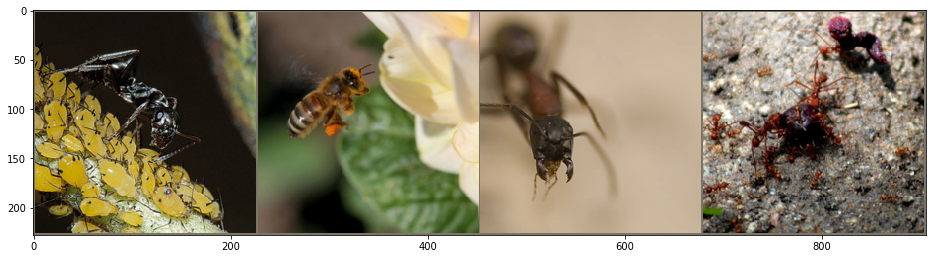

In [0]:
#Let's visualize some training images

#Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#Normalize the batch
out = out.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
out = std * out + mean
out = np.clip(out, 0, 1)

#Plot
fig, ax = plt.subplots(1, 1, figsize = (16,6))
ax.imshow(out)

##Use of Pre-trained AlexNet

In [0]:
#Get AlexNet model
model_conv = torchvision.models.alexnet(pretrained=True)
print(model_conv)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [0]:
#Freeze all layers except the last one

for param in model_conv.parameters():
    param.requires_grad = False 

Now we will swap last layer with a new layer to use it for training of bees vs ants.

In [0]:
# Number of features in the bottleneck layer
num_ftrs = model_conv.classifier[6].in_features

#Substitute it with a new fully connected layer with the same number of inputs but only 2 outputs
#Since this bees and ants dataset is small and different from the ImageNet, we are using a linear classifier
model_conv.classifier[6] = nn.Linear(num_ftrs, 2)

In [0]:
# define cross entropy loss
criterion = nn.CrossEntropyLoss()

# define the optimizer. Note that we tell the optimizer to only update the 
# parameters in the last layer. Also, remember that we have set requires_grad=False
# on all other parameters of the model, so the optimizer wouldn't have gradient
# information on them if we asked it to update all the parameters.
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=1e-4, momentum=0.9)

We will try a larger learning rate of 1e-4 to prevent overfitting. Previously tried parameters was: 0.01, 0.1, 1e-5, 1e-6.

This one looks like the one which gives the best.

We also tried different momentums: 0.5, 0.6, 0.98. The best one is 0.9

In [0]:
# generic training function
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [0]:
train_model(model_conv, criterion, optimizer_conv, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0066 Acc: 1.0000
val Loss: 0.2998 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.3000 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3001 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.0082 Acc: 0.9959
val Loss: 0.3007 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.3000 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3003 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.0057 Acc: 1.0000
val Loss: 0.3018 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.0067 Acc: 0.9959
val Loss: 0.3000 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.0054 Acc: 1.0000
val Loss: 0.3013 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3019 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.3024 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3014 Acc: 0.9346

Ep